In [23]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Masking
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback

import seaborn as sns
from matplotlib import pyplot as plt

In [24]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/minh-notebooks/demonstrated data/final-sample-appending.zarr', consolidated=True)
zarr_ds_sorted = zarr_ds.sortby('time')
zarr_ds_sorted

<xarray.Dataset>
Dimensions:          (time: 3287, lat: 81, lon: 81)
Coordinates:
  * lat              (lat) float32 25.0 24.75 24.5 24.25 ... 5.75 5.5 5.25 5.0
  * lon              (lon) float32 60.0 60.25 60.5 60.75 ... 79.5 79.75 80.0
  * time             (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2001-12-31
Data variables: (12/14)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    direction        (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    sla              (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    ...               ...
    u_curr           (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    u_wind           (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-11-11
    geospatial_lat_max:         25.0
    geospatial_lat_min:         5.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     OSCAR, ERA5 Reanalysis, Copernicus Climate Ch...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2002-12-31T23:59:59
    time_coverage_start:        2000-01-01T00:00:00
    title:                      Sample of Climate Data for Coastal Upwelling ...

In [25]:
zarr_new = zarr_ds_sorted.sel(lat=slice(35, -5), lon=slice(45,90))

In [26]:
def create_data_map(variable_name, start_date='1993-01-01', end_date='2001-12-31'):
    date_range = pd.date_range(start=start_date, end=end_date)

    zarr_dates = pd.to_datetime(zarr_new.time.values)

    # times we don't have labels
    skip_ranges = [
        pd.date_range(start='1997-02-01', end='1997-02-28'),
        pd.date_range(start='2001-11-01', end='2001-11-30')
    ]

    date_to_data_map = {}

    for date in date_range:
        if any(date in skip_range for skip_range in skip_ranges):
            continue
        if date in zarr_dates:
            data = getattr(zarr_new, variable_name).sel(time=str(date.date())).values
            if not np.all(np.isnan(data)): 
                mean_val = np.nanmean(data)
                normalized_day_data = data - mean_val
                normalized_day_data = np.nan_to_num(normalized_day_data, nan=0.0)
                
                date_to_data_map[date] = normalized_day_data

    return date_to_data_map

data_map = create_data_map('speed')
# direction_data_map = create_data_map('direction')

In [27]:
def get_labels(start_date, end_date):
    # Convert input dates to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # List to store all group labels
    all_labels = pd.Series(dtype=int)

    # Initialize current date to start_date
    curr_date = start_date

    while curr_date <= end_date:
        year = curr_date.year
        month = curr_date.month
        
        file_name = f"/home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            curr_date += relativedelta(months=1)
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

        # Move to the next month
        curr_date += relativedelta(months=1)

    print(all_labels.shape)
    return all_labels

# Call the function with your specific start and end date
labels = get_labels('1993-01-01', '2001-12-31')

Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199301_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199302_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199303_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199304_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199305_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199306_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199307_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199308_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199309_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199310_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0

In [28]:
valid_dates = list(data_map.keys())
filtered_labels = labels[labels.index.isin(valid_dates)]

In [29]:
assert len(data_map) == len(filtered_labels)

In [30]:
all_labels_reshaped = filtered_labels.values.ravel()

In [31]:
X = np.array(list(data_map.values()))

X = np.expand_dims(X, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X, all_labels_reshaped, test_size=0.2, random_state=42)

In [40]:
sample_data = next(iter(data_map.values()))
input_shape = (sample_data.shape[0], sample_data.shape[1], 1)

In [42]:
# Define the model
base_model = EfficientNetB0(include_top=False, weights=None, input_shape=input_shape)

In [43]:
# Add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# And a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tqdm_callback = TqdmCallback(verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[tqdm_callback])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

15/15 [==============================] - 2s 71ms/step - loss: 0.2857 - accuracy: 0.9563
Accuracy: 0.9563318490982056


In [45]:
data = []  # List to store each row of the DataFrame

# Iterate through all dates in date_to_data_map
for date, day_data in data_map.items():
    actual_val = filtered_labels[date]

    # Pre-process the day data and predict
    day_data = np.nan_to_num(day_data, nan=0.0)  # Replace NaN with 0
    day_data = np.expand_dims(day_data, axis=(0, -1))  # Add a new dimension for the batch and channel

    prediction = model.predict(day_data, verbose=0)

    # Append the data for the current date to the list
    data.append({'time': date, 'actual_val': actual_val, 'predicted_val': prediction[0][0]})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Check the DataFrame
print(df)

           time  actual_val  predicted_val
0    1993-01-01           0   2.291213e-07
1    1993-01-02           0   1.983046e-06
2    1993-01-03           0   2.537691e-07
3    1993-01-04           0   2.416156e-06
4    1993-01-05           0   1.010694e-06
...         ...         ...            ...
2285 2001-10-27           0   5.967249e-10
2286 2001-10-28           0   1.104324e-07
2287 2001-10-29           0   4.333833e-25
2288 2001-10-30           0   0.000000e+00
2289 2001-10-31           0   0.000000e+00

[2290 rows x 3 columns]


In [46]:
print(len(df[(df['actual_val'] == 0) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 0)]))
print(len(df[(df['actual_val'] == 1) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 1)]))

3
2033
239
257


/tmp/ipykernel_157/2030461022.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
/tmp/ipykernel_157/2030461022.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1'

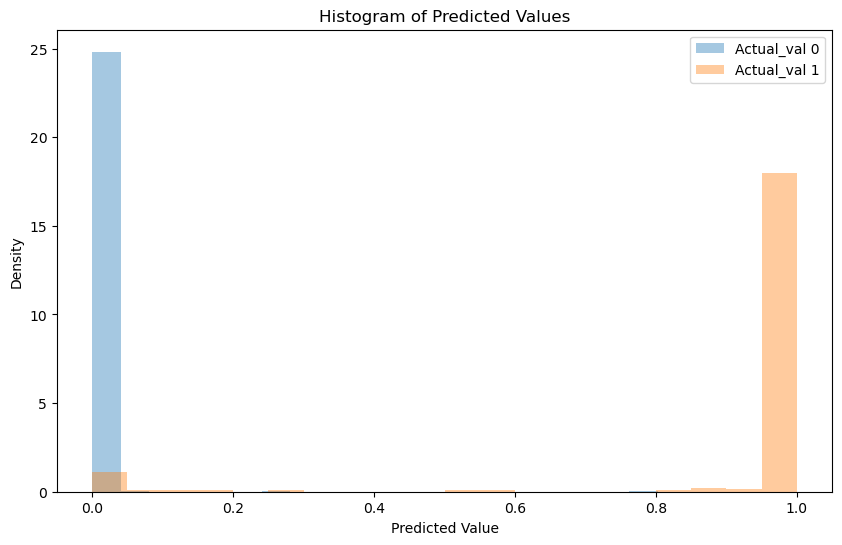

In [47]:
# Convert 'predicted_val' to float
df['predicted_val'] = df['predicted_val'].apply(lambda x: float(x[0]) if isinstance(x, (list, np.ndarray)) else float(x))

# Separate the data into two groups based on 'actual_val'
group0 = df[df['actual_val'] == 0]['predicted_val']
group1 = df[df['actual_val'] == 1]['predicted_val']

# Create the histogram plot
plt.figure(figsize=(10, 6))
sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1')

# Set the labels and title
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('Histogram of Predicted Values')
plt.legend()

# Show the plot
plt.show()

In [48]:
model.save('efficientnet_wind_1993_2001.keras')

In [64]:
def predict_for_date(input_date):
    # Convert user input to pandas Timestamp
    date_timestamp = pd.Timestamp(input_date)
    
    # Check if the timestamp is in the data_map
    if date_timestamp not in data_map:
        raise ValueError(f"The date {input_date} is not available in the data map.")
        
    day_data = data_map[date_timestamp]
    day_data = np.nan_to_num(day_data, nan=0.0)
    day_data = np.expand_dims(day_data, axis=(0, -1))
    prediction = model.predict(day_data)
    return prediction

In [75]:
date = '1993-01-03'
print(predict_for_date(date))

1/1 [==============================] - 0s 25ms/step
[[2.5376906e-07]]
